In [7]:
using Images
using PyPlot


function gauss2d(sigma, fsize)
    m, n = fsize[1], fsize[2]
    g = [exp(-(X.^2 + Y.^2) / (2*sigma.^2)) for X=-floor(m/2):floor(m/2), Y=-floor(n/2):floor(n/2)]
    return g/sum(g)
end

function createfilters()
  dx = [-0.5 0 0.5] # note: imfilter uses correlation
  gy = gauss2d(0.8,[3,1])
  fx = gy*dx
  fy = Array(fx')
  return fx::Array{Float64,2}, fy::Array{Float64,2}
end

function filterimage(I::Array{Float32,2},fx::Array{Float64,2},fy::Array{Float64,2})
  Ix = imfilter(I,centered(fx))
  Iy = imfilter(I,centered(fy))
  return Ix::Array{Float64,2}, Iy::Array{Float64,2}
end

function detectedges(Ix::Array{Float64,2}, Iy::Array{Float64,2}, thr::Float64)
  edges = sqrt.(Ix.^2 + Iy.^2)
  # mask = 1 .- (edges .< thr) .* 1.0
  # edges = edges .* mask
  edges[edges .< thr] .= 0
  return edges::Array{Float64,2}
end


function nonmaxsupp(edges::Array{Float64,2},Ix::Array{Float64,2},Iy::Array{Float64,2})
  # store result here
  edges2 = copy(edges)

  # expand by one pixel
  padedges = padarray(edges, Fill(0.0, (1,1), (1,1)))

  # edge orientation in [-90, 90]
  orientation = atan.(Iy./Ix)

  # store indices
  r = (1:size(edges,1)) # Offset array are weird: they start at 0
  c = (1:size(edges,2))

  # suppress non-maxima in 4 directions

  pi8 = pi/8 # 22.5 degrees

  # top-to-bottom edges: theta in [-90, -67.5] or (67.5, 90]
  is_theta =  (orientation .<= -3*pi8) .| (orientation .> 3*pi8)
  is_nonmax = padedges[r,c] .< max.(padedges[r.-1,c],padedges[r.+1,c])
  edges2[is_theta .& is_nonmax] .= 0

  # left-to-right edges: theta in (-22.5, 22.5]
  is_theta = (orientation .> -pi8) .& (orientation .<= pi8)
  is_nonmax = padedges[r,c] .< max.(padedges[r,c.-1],padedges[r,c.+1])
  edges2[is_theta .& is_nonmax] .= 0

  # bottomleft-to-topright edges: theta in (22.5, 67.5]
  is_theta = (orientation .> pi8) .& (orientation .<= 3*pi)
  is_nonmax = padedges[r,c] .< max.(padedges[r.-1,c.-1],padedges[r.+1,c.+1])
  edges2[is_theta .& is_nonmax] .= 0

  # topleft-to-bottomright edges: theta in [-67.5, -22.5]
  is_theta = (orientation .> -3*pi8) .& (orientation .<= -pi8)
  is_nonmax = padedges[r,c] .< max.(padedges[r.+1,c.-1],padedges[r.-1,c.+1])
  edges2[is_theta .& is_nonmax] .= 0

  edges2 =  1.0 .* (edges2 .> 0)
  return edges2::Array{Float64,2}
end

return nothing

In [8]:
# load image
img = imread("a1p4.png")

# create filters
fx, fy = createfilters()
display(fx), display(fy)
return nothing

3×3 Array{Float64,2}:
 -0.119497  0.0  0.119497
 -0.261006  0.0  0.261006
 -0.119497  0.0  0.119497

3×3 Array{Float64,2}:
 -0.119497  -0.261006  -0.119497
  0.0        0.0        0.0     
  0.119497   0.261006   0.119497

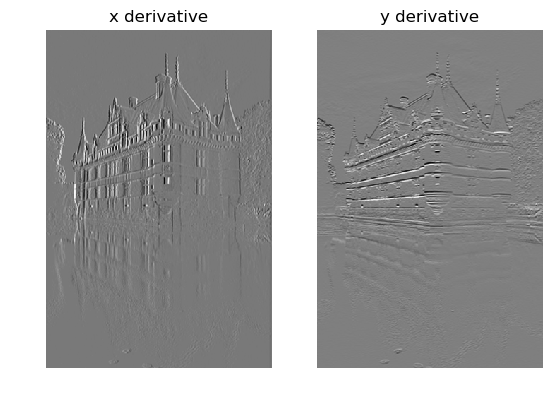

In [6]:
# filter image
imgx, imgy = filterimage(img, fx, fy)

# show filter results
figure()
subplot(121)
imshow(imgx, "gray", interpolation="none")
title("x derivative")
axis("off")
subplot(122)
imshow(imgy, "gray", interpolation="none")
title("y derivative")
axis("off")
return nothing

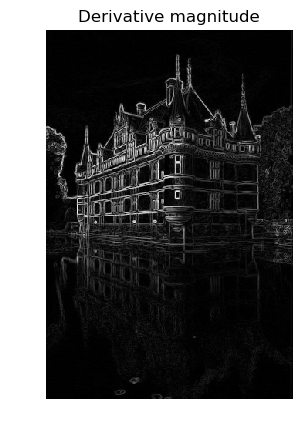

In [9]:
# show gradient magnitude
figure()
imshow(sqrt.(imgx.^2 + imgy.^2),"gray", interpolation="none")
axis("off")
title("Derivative magnitude")
return nothing

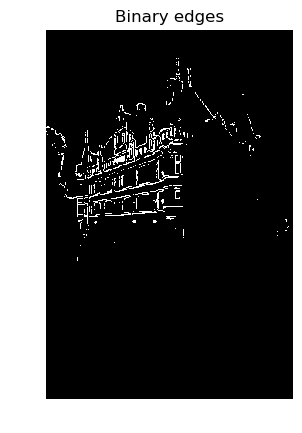

In [10]:
# threshold derivative
threshold = 0.2
edges = detectedges(imgx,imgy,threshold)
figure()
imshow(edges.>0, "gray", interpolation="none")
axis("off")
title("Binary edges")
return nothing

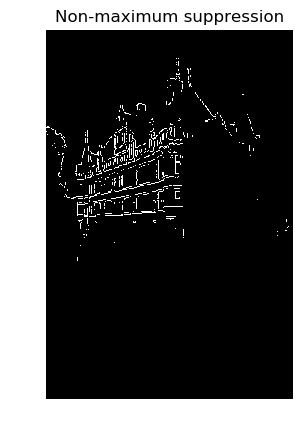

PyObject Text(0.5, 1.0, 'Non-maximum suppression')

In [11]:
# non maximum suppression
edges2 = nonmaxsupp(edges,imgx,imgy)
figure()
imshow(edges2,"gray", interpolation="none")
axis("off")
title("Non-maximum suppression")